# Simulated Instrument Signal

eg how to simulate signal of non astrophysical origin, ground, atmosphere ect

In this lesson we cover three TOAST operators for simulating noise and systematics:
* `OpSimNoise` for simulating instrumental noise
* `OpSimAtmosphere` for simulating atmospheric noise
* `OpSimSSS` for simulating scan-synchronous signal (typically ground pick-up)
We also introduce `TODGround`, a synthetic `TOD` class that simulates constant elevation scanning.

In [1]:
# Are you using a special reservation for a workshop?
# If so, set it here:
nersc_reservation = "toast3"

# Load common tools for all lessons
import sys
sys.path.insert(0, "..")
from lesson_tools import (
    check_nersc,
    fake_focalplane
)
nersc_host, nersc_repo, nersc_resv = check_nersc(reservation=nersc_reservation)

# Capture C++ output in the jupyter cells
%reload_ext wurlitzer


Running on NERSC machine 'cori'
  with access to repos: mp107
Using default repo mp107


## Generating a TOAST data object with one constant elevation scan

We begin by generating an observing schedule containing a single observation.  We define one circular patch at (40$^\circ$, -40$^\circ$) RA, DEC with a 10$^\circ$ radius.

In [2]:
! toast_ground_schedule.py \
    --site-lat "-22.958064" \
    --site-lon "-67.786222" \
    --site-alt 5200 \
    --site-name Atacama \
    --telescope LAT \
    --start "2020-01-01 04:00:00" \
    --stop "2020-01-01 05:00:00" \
    --patch-coord C \
    --patch small_patch,1,40,-40,10 \
    --ces-max-time 86400 \
    --out schedule.txt

! cat schedule.txt

TOAST INFO: Adding patch "small_patch"
TOAST INFO: Center-and-width format
TOAST INFO: Global timer: toast_ground_schedule:  0.02 seconds (1 calls)
#Site            Telescope        Latitude [deg] Longitude [deg]   Elevation [m]
 Atacama         LAT                     -22.958         -67.786          5200.0
#Start time UTC       Stop time UTC        Start MJD      Stop MJD       Patch name                          Az min   Az max   El       R/S   Sun el1  Sun az1  Sun el2  Sun az2  Moon el1 Moon az1 Moon el2 Moon az2 Phase Pass  Sub
 2020-01-01 04:00:00  2020-01-01 04:53:00    58849.166667   58849.203472 small_patch                           230.06   242.72    38.03 S       -43.25   190.86   -43.78   174.05    -7.65   256.93   -19.09   251.31  0.32     0   0


For simulating atmospheric noise, we'll also need a TOAST weather file, which contains the historic distributions of temperature, wind, pressure and water vapor at a fixed site. The file is arranged by month and hour of the day to capture seasonal and diurnal variation in these parameters.  Here we fetch the weather file for Atacama. There is a another file for Pole. It contains data on the seasonal and diurnal variation of wind speed ect from historical data. 

In [3]:
! [[ ! -e weather_Atacama.fits ]] && wget http://portal.nersc.gov/project/cmb/toast_data/example_data/weather_Atacama.fits

--2019-10-15 09:18:35--  http://portal.nersc.gov/project/cmb/toast_data/example_data/weather_Atacama.fits
Resolving portal.nersc.gov (portal.nersc.gov)... 128.55.201.128
Connecting to portal.nersc.gov (portal.nersc.gov)|128.55.201.128|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://portal.nersc.gov/project/cmb/toast_data/example_data/weather_Atacama.fits [following]
--2019-10-15 09:18:35--  https://portal.nersc.gov/project/cmb/toast_data/example_data/weather_Atacama.fits
Connecting to portal.nersc.gov (portal.nersc.gov)|128.55.201.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2180160 (2.1M) [image/fits]
Saving to: ‘weather_Atacama.fits’

weather_Atacama.fit 100%[===================>]   2.08M  --.-KB/s    in 0.009s  

2019-10-15 09:18:35 (223 MB/s) - ‘weather_Atacama.fits’ saved [2180160/2180160]



### TODGround object

Typical TOAST pipelines like [toast_ground_sim.py](https://github.com/hpc4cmb/toast/blob/master/pipelines/toast_ground_sim.py#L423) create synthetic observations by loading the schedule from file and then creating instances of [TODGround](https://github.com/hpc4cmb/toast/blob/master/src/toast/todmap/sim_tod.py#L707) according to the observing schedule. This is most easily accomplished with [toast.pipeline_tools](https://github.com/hpc4cmb/toast/tree/master/src/toast/pipeline_tools).

In [4]:
import toast
import toast.pipeline_tools
from toast.mpi import MPI

import numpy as np
import matplotlib.pyplot as plt

mpiworld, procs, rank = toast.mpi.get_world()
comm = toast.mpi.Comm(mpiworld)

# A pipeline would create the args object with argparse

class args:
    split_schedule = None
    schedule = "schedule.txt"
    sort_schedule = False  # Matters for parallelization
    weather = "weather_Atacama.fits"
    sample_rate = 10  # Hz
    scan_rate = 1.0  # deg / s
    # Use an artifially low acceleration to show the turn-arounds better
    scan_accel = 0.1  # deg / s^2
    hwp_rpm = None
    hwp_step_deg = None
    hwp_step_time_s = None
    fov = 3.0  # Field-of-view in degrees

# Create a fake focalplane, we could also load one from file.
# The Focalplane class interprets the focalplane dictionary
# created by fake_focalplane() but it can also load the information
# from file.

focalplane = toast.pipeline_tools.Focalplane(
    fake_focalplane(fov=args.fov), sample_rate=args.sample_rate
)

# Load the observing schedule, append weather and focalplane to it
    
schedules = toast.pipeline_tools.load_schedule(args, comm)
toast.pipeline_tools.load_weather(args, comm, schedules)
# There could be more than one observing schedule, but not this time
schedule = schedules[0]
schedule.telescope.focalplane = focalplane

# Create a TODGround object based on the only entry in the schedule

ces = schedule.ceslist[0]  # normally we would loop over entries
totsamples = int((ces.stop_time - ces.start_time) * args.sample_rate)

if comm.comm_group is not None:
    # Available detectors should be split between processes in the group
    ndetrank = comm.comm_group.size
else:
    ndetrank = 1
    
telescope = schedule.telescope  # shorthand
        
tod = toast.todmap.TODGround(
    comm.comm_group,
    telescope.focalplane.detquats,
    totsamples,
    detranks=ndetrank,
    firsttime=ces.start_time,
    rate=args.sample_rate,
    site_lon=telescope.site.lon,
    site_lat=telescope.site.lat,
    site_alt=telescope.site.alt,
    azmin=ces.azmin,
    azmax=ces.azmax,
    el=ces.el,
    scanrate=args.scan_rate,
    scan_accel=args.scan_accel,
    #CES_start=None,
    #CES_stop=None,
    #sun_angle_min=args.sun_angle_min,
    #coord=args.coord,
    #sampsizes=None,
    #report_timing=args.debug,
    hwprpm=args.hwp_rpm,
    hwpstep=args.hwp_step_deg,
    hwpsteptime=args.hwp_step_time_s,
)

The `TODGround` objects have capabilities that regular TOD objects do not.  Specifically, they can produce detector and boresight pointing in both celestial and horizontal coordinate systems.  Here we plot the boresight azimuth and identify the stable science scans.

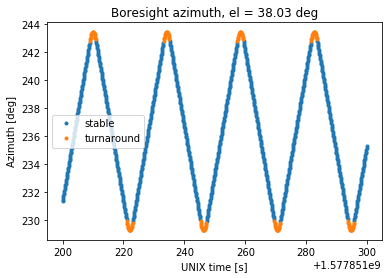

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

ind = slice(0, 1000)
times = tod.local_times()[ind]
cflags = tod.local_common_flags()[ind]
az = tod.read_boresight_az()[ind]

turnaround = cflags & tod.TURNAROUND != 0
stable = np.logical_not(turnaround)

plt.plot(times[stable], np.degrees(az[stable]), '.', label="stable")
plt.plot(times[turnaround], np.degrees(az[turnaround]), '.', label="turnaround")
ax = plt.gca()
ax.set_xlabel("UNIX time [s]")
ax.set_ylabel("Azimuth [deg]")
ax.set_title("Boresight azimuth, el = {} deg".format(np.degrees(tod._el)))
plt.legend()

Here we get the horizontal and celestial pointing and plot the location of every 10th sample

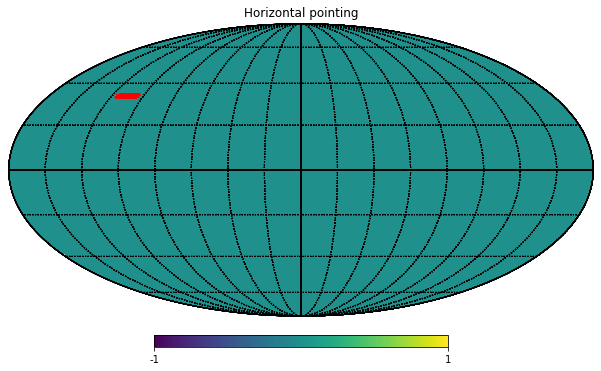

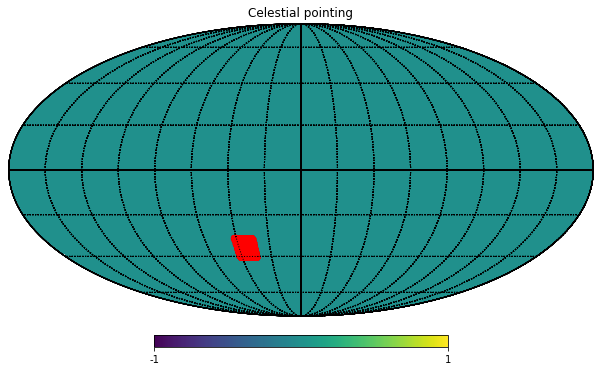

In [6]:
import healpy

healpy.mollview(np.zeros(12), title="Horizontal pointing")
for det in tod.local_dets:
    quat_azel = tod.read_pntg(det, azel=True)[::10]
    az, el = toast.qarray.to_position(quat_azel)
    healpy.projplot(az, el, 'r-')
    healpy.graticule(22.5, verbose=False)

healpy.mollview(np.zeros(12), title="Celestial pointing")
for det in tod.local_dets:
    quat_radec = tod.read_pntg(det)[::10]
    ra, dec = toast.qarray.to_position(quat_radec)
    healpy.projplot(ra, dec, 'r.', ms=1)
    healpy.graticule(22.5, verbose=False)

### TOAST data

In [8]:
# Now embed the TOD in an observation dictionary and add other necessary metadata

obs = {}
obs["name"] = "CES-{}-{}-{}-{}-{}".format(
    telescope.site.name, telescope.name, ces.name, ces.scan, ces.subscan
)
obs["tod"] = tod
obs["baselines"] = None
obs["noise"] = telescope.focalplane.noise
obs["id"] = int(ces.mjdstart * 10000)   #id is used as a noise seed when generating montecarlo something
obs["intervals"] = tod.subscans
obs["site"] = telescope.site
obs["site_name"] = telescope.site.name
obs["site_id"] = telescope.site.id
obs["altitude"] = telescope.site.alt
obs["weather"] = telescope.site.weather
obs["telescope"] = telescope
obs["telescope_name"] = telescope.name
obs["telescope_id"] = telescope.id
obs["focalplane"] = telescope.focalplane.detector_data
obs["fpradius"] = telescope.focalplane.radius
obs["start_time"] = ces.start_time
obs["season"] = ces.season
obs["date"] = ces.start_date
obs["MJD"] = ces.mjdstart
obs["rising"] = ces.rising
obs["mindist_sun"] = ces.mindist_sun
obs["mindist_moon"] = ces.mindist_moon
obs["el_sun"] = ces.el_sun
    

In [9]:
for key, value in obs.items():
    if key == "intervals":
        print("intervals = [{} ... {}] ({} in total)".format(value[0], value[-1], len(value)))
    else:
        print("{} = {}".format(key, value))

name = CES-Atacama-LAT-small_patch-0-0
tod = <TODGround
  14 total detectors and 31800 total samples
  Using MPI communicator None
    In grid dimensions 1 sample ranks x 1 detranks
  Process at (0, 0) in grid has data for:
    Samples 0 - 31799 (inclusive)
    Detectors:
      0A
      0B
      1A
      1B
      2A
      2B
      3A
      3B
      4A
      4B
      5A
      5B
      6A
      6B
    Cache contains 2575800 bytes
>
baselines = None
noise = <toast.tod.sim_noise.AnalyticNoise object at 0x2aaaaeea7a58>
id = 588491666
intervals = [<Interval 1577851199.0 - 1577851209.0 (-10 - 89)> ... <Interval 1577854369.1 - 1577854379.2 (31691 - 31791)>] (263 in total)
site = (Site 'Atacama' : ID = 0, lon = -67.786, lat = -22.958, alt = 5200.0 m, weather = (Weather : 'weather_Atacama.fits', site = 0, time = None, year = None, month = None, hour = None, realization = 0))
site_name = Atacama
site_id = 0
altitude = 5200.0
weather = (Weather : 'weather_Atacama.fits', site = 0, time = None, year

In [10]:
data = toast.Data(comm)
data.obs.append(obs)

## Simulating instrument noise

Instrumental noise simulation is based on the TOAST [Noise](https://github.com/hpc4cmb/toast/blob/master/src/toast/tod/noise.py#L8) object appended to each observation.

[src/toast/tod/sim_det_noise.py](https://github.com/hpc4cmb/toast/blob/master/src/toast/tod/sim_det_noise.py#L16)

detectors: ['0A', '0B', '1A', '1B', '2A', '2B', '3A', '3B', '4A', '4B', '5A', '5B', '6A', '6B']


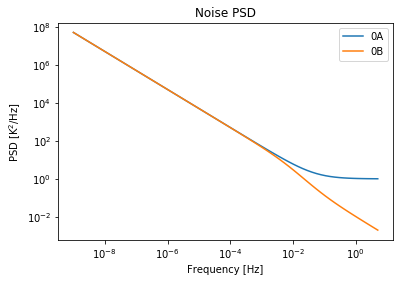

In [11]:
obs = data.obs[0]
noise = obs["noise"]
print("detectors:", noise.detectors)

# Get and plot noise PSD for det1
det1 = noise.detectors[0]
freq1 = noise.freq(det1)
psd1 = noise.psd(det1)
plt.loglog(freq1, psd1, label=det1)

# get and plot det2 but manipulate the noise PSD to suppress high frequency noise
det2 = noise.detectors[1]
freq2 = noise.freq(det2)
psd2 = noise.psd(det2)
psd2 *= 1e-2 / (freq2 + 1e-2)
plt.loglog(freq2, psd2, label=det2)

ax = plt.gca()
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("PSD [K$^2$/Hz]")
ax.set_title("Noise PSD")
plt.legend(loc="best")

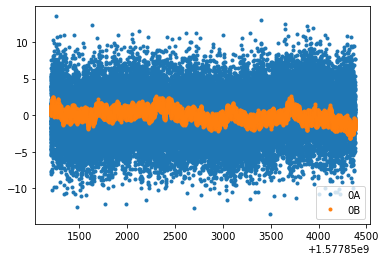

In [12]:

simnoise = toast.tod.OpSimNoise(out="noise", realization=0)
toast.tod.OpCacheClear("noise").exec(data) #in case this is being run repeatedly
simnoise.exec(data)
tod = obs["tod"]
times = tod.local_times()
for det in [det1, det2]:
    simulated = tod.local_signal(det, "noise")
    plt.plot(times, simulated, ".", label=det)
ax.set_xlabel("Unix time [s]")
ax.set_ylabel("Noise [K]")
ax.set_title("Simulated noise")
plt.legend(loc="best") #plt shows the difference our change in noise psd made

By default the `Noise` object includes a diagonal mixing matrix and produces uncorrelated detector noise.  Let's add a strongly correlated low frequency component to the `Noise` object.

In [13]:
def print_mixmatrix(noise): #introduce corelations between detectors as well as previous corelations in time
    print("{:10}key".format(""))
    print("{:10}".format("detector"), end="")
    for key in noise.keys:
        print("{:>4}".format(key), end="")
    print()
    print("-" * 80)
    for det in noise.detectors:
        print("{:8} :".format(det), end="")
        for key in noise.keys:
            weight = noise.weight(det, key)
            if np.abs(weight) < 1e-10:
                print("{:4}".format(""), end="")
            else:
                print("{:4}".format(noise.weight(det, key)), end="")
        print()

print("Original mixing matrix")
print_mixmatrix(noise)

Original mixing matrix
          key
detector    0A  0B  1A  1B  2A  2B  3A  3B  4A  4B  5A  5B  6A  6B
--------------------------------------------------------------------------------
0A       :   1                                                    
0B       :       1                                                
1A       :           1                                            
1B       :               1                                        
2A       :                   1                                    
2B       :                       1                                
3A       :                           1                            
3B       :                               1                        
4A       :                                   1                    
4B       :                                       1                
5A       :                                           1            
5B       :                                               1        
6A       : 

 We will instantiate a new Noise object with all the original inputs and an additional thermal mode.  We could also manipulate the existing noise object but this approach is more representative of how pipelines currently use `Noise`.

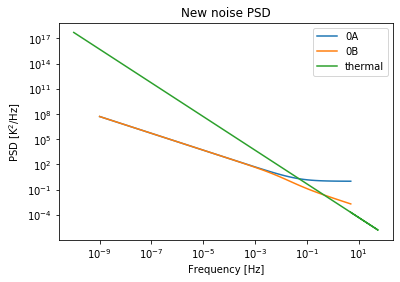

In [14]:
#creating a new noise object
detectors = []
freqs = {}
psds = {}
mixmatrix = {}
indices = {}
for det in noise.detectors:
    detectors.append(det)
    freqs[det] = noise.freq(det).copy()
    psds[det] = noise.psd(det).copy()
    indices[det] = noise.index(det)
    # We do not just copy the old mixing matrix because it is not stored for the trivial case
    mixmatrix[det] = {}
    for key in noise.keys:
        weight = noise.weight(det, key)
        if weight != 0:
            mixmatrix[det][key] = weight

# Create a new PSD and add it to the Noise object inputs
correlated_name = "thermal"
freq = np.logspace(-10, 2)
freq[freq < args.sample_rate / 2]
freq[-1] = args.sample_rate / 2
psd = freq ** -2 * 5e-3
freqs[correlated_name] = freq
psds[correlated_name] = psd
indices[correlated_name] = 999999  #a new seed so that it isn't using the same as the other noise
for det in noise.detectors:
    mixmatrix[det][correlated_name] = 1

# Create a completely new Noise object
new_noise = toast.tod.Noise(
    detectors=detectors, freqs=freqs, psds=psds, mixmatrix=mixmatrix, indices=indices
)

plt.figure()
for key in [det1, det2, correlated_name]:
    freq = new_noise.freq(key)
    psd = new_noise.psd(key)
    plt.loglog(freq, psd, label=key)
ax = plt.gca()
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("PSD [K$^2$/Hz]")
ax.set_title("New noise PSD")
plt.legend(loc="best")

In [15]:
print("\nNew mixing matrix")
print_mixmatrix(new_noise)


New mixing matrix
          key
detector    0A  0B  1A  1B  2A  2B  3A  3B  4A  4B  5A  5B  6A  6Bthermal
--------------------------------------------------------------------------------
0A       :   1                                                       1
0B       :       1                                                   1
1A       :           1                                               1
1B       :               1                                           1
2A       :                   1                                       1
2B       :                       1                                   1
3A       :                           1                               1
3B       :                               1                           1
4A       :                                   1                       1
4B       :                                       1                   1
5A       :                                           1               1
5B       :                     

We will now replace the `Noise` in the observation with the one that includes the correlated mode and rerun the simulation

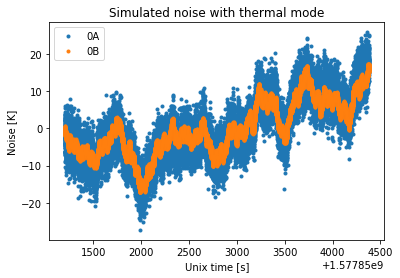

In [16]:
#plot the new noise, now they have both random uncorelated noise and then also correlated thermal noise
obs["noise"] = new_noise
toast.tod.OpCacheClear("new_noise").exec(data)
simnoise = toast.tod.OpSimNoise(out="new_noise", realization=0)
simnoise.exec(data)

plt.figure()
tod = obs["tod"]
times = tod.local_times()
for det in [det1, det2]:
    simulated = tod.local_signal(det, "new_noise")
    plt.plot(times, simulated, ".", label=det)
ax = plt.gca()
ax.set_xlabel("Unix time [s]")
ax.set_ylabel("Noise [K]")
ax.set_title("Simulated noise with thermal mode")
plt.legend(loc="best")

## Atmospheric noise simulation

The atmospheric noise module in TOAST
1. defines a rectangular volume of atmosphere that contains all of the planned lines-of-sight factoring in the wind
2. compresses the volume by determining which elements are actually needed
3. builds the element-element covariance matrix matching the [Errard. et al.](https://arxiv.org/abs/1501.07911) model and instantiates it on the compressed volume
4. optionally caches the volume elements for future use
5. simulates the detector signal by performing line-of-sight integrals through the simulated volume while moving the volume with wind

[src/toast/todmap/sim_det_atm.py](https://github.com/hpc4cmb/toast/blob/master/src/toast/todmap/sim_det_atm.py#L36)

The atmospheric simulation is based on creating realization of the modified Kolmogorov spectrum (Andrews, L. C. 2004, Field Guide to Atmospheric Optics (SPIE), 112):

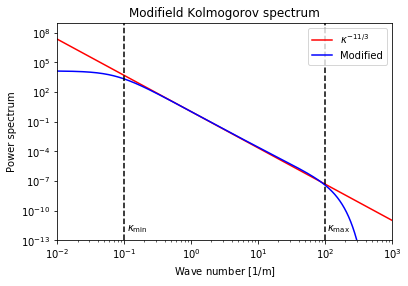

In [17]:
dissipation_scale = .01  # in meters
injection_scale = 10.  # in meters
kappamin = 1 / injection_scale
kappamax = 1 / dissipation_scale

n = 1000000
k = np.linspace(1e-2, kappamax * 10, n)

kl = 0.9 / dissipation_scale
k0 = 0.75 / injection_scale

kkl = k / kl
phi = (1 + 1.802 * kkl - .254 * (kkl) ** (7 / 6)) * np.exp(-kkl ** 2) * (k ** 2 + k0 ** 2) ** ( -11 / 6)

plt.figure()
plt.loglog(k, k ** (-11 / 3), "r-", label="$\kappa^{-11/3}$")
plt.loglog(k, phi, "b-", label="Modified")

ax = plt.gca()
for k, label in [(kappamin, "$\kappa_\mathrm{min}$"), (kappamax, "$\kappa_\mathrm{max}$")]:
    ax.axvline(k, linestyle="--", color="black")
    plt.annotate(label, xy=[k * 1.08, 1e-12])

ax.set_xlabel("Wave number [$1/\mathrm{m}$]")
ax.set_ylabel("Power spectrum")
ax.set_title("Modifield Kolmogorov spectrum")

ax.set_xlim([1e-2, 1e3])
ax.set_ylim([1e-13, 1e9])

plt.legend(loc="upper right");
#modified kolmogorov has two aditional areas, injection and disipation the largest and smallest scales the atmosphere does things at

Here we run an example atmospheric simulation for two different injection scales.  Be patient, they take about a minute to run.

Creating atm_cache_10/6/6/6
Creating atm_cache_300/6/6/6


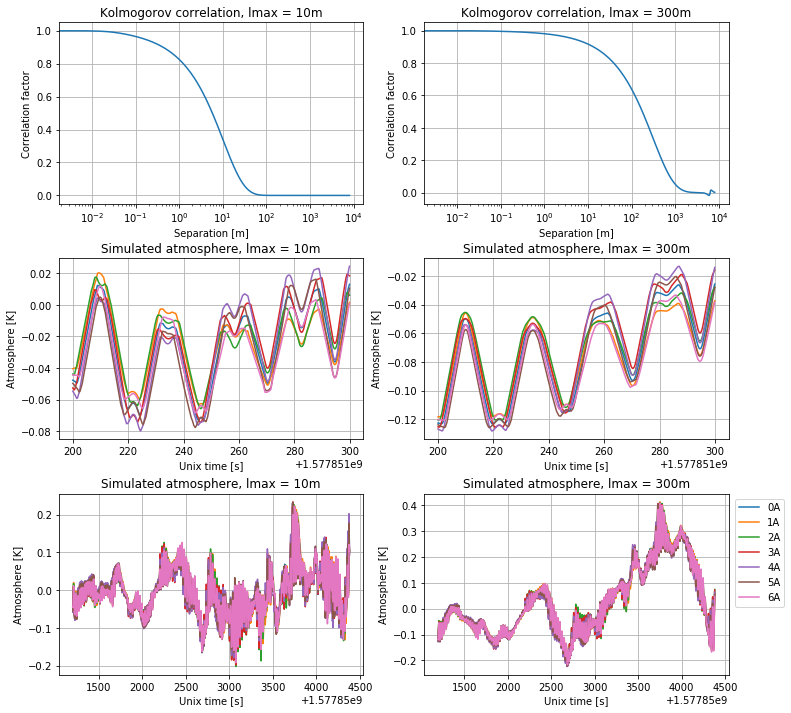

In [18]:
fig = plt.figure(figsize=[6 * 2, 4 * 3])
name = "atmosphere"

# Delete old atmosphere from disk.  We could also set cachedir=None
! rm -rf atm_cache*

# Run the simulation with two different injection scales and plot the resulting TOD

for iplot, lmax in enumerate([10, 300]): #making two atmospheres, one with injection scale length =10m the other with 300m
    cachedir = "atm_cache_{}".format(lmax)
    # Wipe old atmospheric signal
    toast.tod.OpCacheClear(name).exec(data)

    atmsim = toast.todmap.OpSimAtmosphere(
        out=name,
        realization=0,  # Each MC will have a different realization
        zmax=1000,  # maximum altitude to integrate
        lmin_center=0.01,  # Dissipation scale
        lmin_sigma=0,
        lmax_center=lmax,  # Injection scale
        lmax_sigma=0,
        xstep=30, # Volume element size
        ystep=30,
        zstep=30,
        nelem_sim_max=10000,  # Target number of volume elements to consider at a time
        gain=3e-5,  # This gain was calibrated against POLARBEAR data
        # If the wind is strong or the observation is long, the volume becomes
        # too large.  This parameter controls breaking the simulation into
        # disjoint segments
        wind_dist=10000, #whenever the air being observed has moved more thn 10km you split the simulation to avoid any one being too large
        cachedir=cachedir,
        freq=100,
        verbosity=1,  # Print progress to stdout and write out the correlation function
    )
    atmsim.exec(data)
    
    # Pick every second detector because the simulated atmosphere is not polarized
    dets = tod.local_dets[::2]

    # Plot the Kolmogorov correlation function
    ax = fig.add_subplot(3, 2, 1 + iplot)
    kolmo = np.genfromtxt("kolmogorov.txt").T
    ax.semilogx(kolmo[0], kolmo[1])
    ax.set_xlabel("Separation [m]")
    ax.set_ylabel("Correlation factor")
    ax.set_title("Kolmogorov correlation, lmax = {}m".format(lmax))
    ax.grid()

    ax = fig.add_subplot(3, 2, 3 + iplot)
    ind = slice(0, 1000)
    tod = obs["tod"]
    times = tod.local_times()
    for det in dets:
        simulated = tod.local_signal(det, name)
        ax.plot(times[ind], simulated[ind], "-", label=det)
    ax.set_xlabel("Unix time [s]")
    ax.set_ylabel("Atmosphere [K]")
    ax.set_title("Simulated atmosphere, lmax = {}m".format(lmax))
    ax.grid()
    
    ax = fig.add_subplot(3, 2, 5 + iplot)
    for det in dets:
        simulated = tod.local_signal(det, name)
        ax.plot(times, simulated, "-", label=det)
    ax.set_xlabel("Unix time [s]")
    ax.set_ylabel("Atmosphere [K]")
    ax.set_title("Simulated atmosphere, lmax = {}m".format(lmax))
    ax.grid()
    
plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1.00))
plt.subplots_adjust(hspace=0.3)

## Ground (scan-synchronous) signal

TOAST includes a new module for simulating scan-synchronous signals.  It works by sampling a provided or on-the-fly synthesized low resolution map using the horizontal detector pointing instead of sky pointing.

[src/toast/todmap/sss.py](https://github.com/hpc4cmb/toast/blob/master/src/toast/todmap/sss.py#L23)

Sigma is 76.438962 arcmin (0.022235 rad) 
-> fwhm is 180.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 76.438962 arcmin (0.022235 rad) 
-> fwhm is 180.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


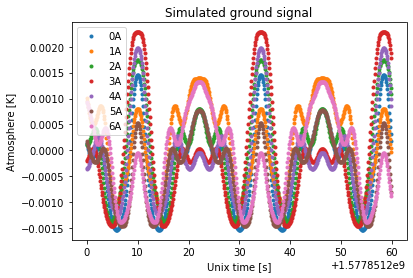

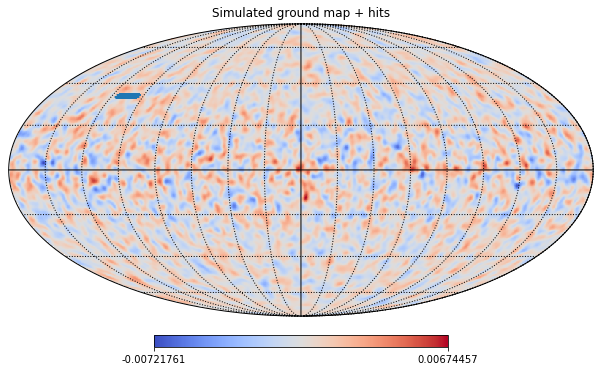

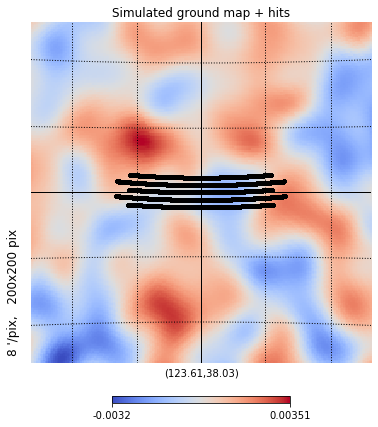

In [19]:
toast.tod.OpCacheClear("sss").exec(data)

sim_sss = toast.todmap.OpSimScanSynchronousSignal(
    out="sss",
    realization=0,
    nside=512,    # internal resolution for the simulated ground map
    fwhm=3,      # smoothing scale for the ground map
    scale=1e-3,   # RMS for observations at el=45 deg
    lmax=512,     # expansion lmax
    power=-1,     # power law that suppresses ground signal at higher elevation
    path=None,    # alternative ground map in Healpix format, will override nside, scale, lmax and power
)

sim_sss.exec(data)

tod = obs["tod"]
times = tod.local_times()
ind = slice(0, 600)
for det in tod.local_dets[::2]:
    simulated = tod.local_signal(det, "sss")
    plt.plot(times[ind], simulated[ind], ".", label=det)
ax = plt.gca()
ax.set_xlabel("Unix time [s]")
ax.set_ylabel("Atmosphere [K]")
ax.set_title("Simulated ground signal")
plt.legend(loc="best")

# The ground map is simulated on-the-fly and discarded afterwards.  By default, each observation gets
# an entirely independent ground map.  Here is an example:

weather = obs["weather"]
weather.set(0, 0, 0)
key1, key2, counter1, counter2 = sim_sss._get_rng_keys(obs)
ground_map = sim_sss._simulate_sss(key1, key2, counter1, counter2, weather, mpiworld)

healpy.mollview(ground_map, cmap="coolwarm", title="Simulated ground map + hits")
for det in tod.local_dets[::2]:
    quat_azel = tod.read_pntg(det, azel=True)
    theta, phi = toast.qarray.to_position(quat_azel)
    healpy.projplot(theta, phi, '-')
healpy.graticule(22.5, verbose=False)

healpy.gnomview(
    ground_map,
    cmap="coolwarm",
    title="Simulated ground map + hits",
    rot=[360 - .5 * (ces.azmin + ces.azmax), ces.el],
    reso=8,
)
for det in tod.local_dets[::2]:
    quat_azel = tod.read_pntg(det, azel=True)
    theta, phi = toast.qarray.to_position(quat_azel)
    healpy.projplot(theta, phi, 'k.')
healpy.graticule(5, verbose=False)
